In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from collections import deque

# --- GPU SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Running on device: cpu


In [2]:
class VarShareLinear(nn.Module):
    def __init__(self, in_features, out_features, num_tasks, prior_sigma=0.1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_tasks = num_tasks
        self.prior_sigma = prior_sigma
        
        # 1. Shared Base
        self.weight_shared = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias_shared = nn.Parameter(torch.Tensor(out_features))
        
        # 2. Task Specific
        self.mu_specific = nn.Parameter(torch.zeros(num_tasks, out_features, in_features))
        # Init Rho to -5.0 (Sigma ~ 0.006) to start very deterministic/stable
        self.rho_specific = nn.Parameter(torch.ones(num_tasks, out_features, in_features) * -5.0)
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight_shared, a=np.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight_shared)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.bias_shared, -bound, bound)

    def forward(self, x, task_ids):
        # Shared Path
        out_shared = F.linear(x, self.weight_shared, self.bias_shared)
        
        # Variational Path
        batch_mus = self.mu_specific[task_ids]     
        batch_rhos = self.rho_specific[task_ids]   
        batch_sigmas = F.softplus(batch_rhos)
        
        # Reparameterization
        epsilon = torch.randn_like(batch_sigmas)
        delta_weight = batch_mus + (batch_sigmas * epsilon)
        
        # Batch Matmul: [B, 1, In] @ [B, In, Out] -> [B, 1, Out]
        out_specific = torch.bmm(x.unsqueeze(1), delta_weight.transpose(1, 2)).squeeze(1)
        
        return out_shared + out_specific

    def get_kl_loss(self):
        sigmas = F.softplus(self.rho_specific)
        var_q = sigmas ** 2
        var_p = self.prior_sigma ** 2
        
        # Sum over all dims
        kl = 0.5 * (torch.log(torch.tensor(var_p, device=device)) - torch.log(var_q) 
                    + (var_q + self.mu_specific**2) / var_p - 1)
        return kl.sum()

In [3]:
class VarShareLinear(nn.Module):
    def __init__(self, in_features, out_features, num_tasks, prior_sigma=0.1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_tasks = num_tasks
        self.prior_sigma = prior_sigma
        
        # 1. Shared Base
        self.weight_shared = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias_shared = nn.Parameter(torch.Tensor(out_features))
        
        # 2. Task Specific
        self.mu_specific = nn.Parameter(torch.zeros(num_tasks, out_features, in_features))
        # Init Rho to -5.0 (Sigma ~ 0.006) to start very deterministic/stable
        self.rho_specific = nn.Parameter(torch.ones(num_tasks, out_features, in_features) * -5.0)
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight_shared, a=np.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight_shared)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.bias_shared, -bound, bound)

    def forward(self, x, task_ids):
        # Shared Path
        out_shared = F.linear(x, self.weight_shared, self.bias_shared)
        
        # Variational Path
        batch_mus = self.mu_specific[task_ids]     
        batch_rhos = self.rho_specific[task_ids]   
        batch_sigmas = F.softplus(batch_rhos)
        
        # Reparameterization
        epsilon = torch.randn_like(batch_sigmas)
        delta_weight = batch_mus + (batch_sigmas * epsilon)
        
        # Batch Matmul: [B, 1, In] @ [B, In, Out] -> [B, 1, Out]
        out_specific = torch.bmm(x.unsqueeze(1), delta_weight.transpose(1, 2)).squeeze(1)
        
        return out_shared + out_specific

    def get_kl_loss(self):
        sigmas = F.softplus(self.rho_specific)
        var_q = sigmas ** 2
        var_p = self.prior_sigma ** 2
        
        # Sum over all dims
        kl = 0.5 * (torch.log(torch.tensor(var_p, device=device)) - torch.log(var_q) 
                    + (var_q + self.mu_specific**2) / var_p - 1)
        return kl.sum()

In [ ]:
class VarShareDQN(nn.Module):
    def __init__(self, state_dim, action_dim, num_tasks):
        super().__init__()
        self.l1 = VarShareLinear(state_dim, 64, num_tasks)
        self.l2 = VarShareLinear(64, 64, num_tasks)
        self.l3 = VarShareLinear(64, action_dim, num_tasks)
        self.to(device) # Move entire model to GPU
        
    def forward(self, state, task_id):
        x = F.relu(self.l1(state, task_id))
        x = F.relu(self.l2(x, task_id))
        return self.l3(x, task_id)
    
    def get_total_kl(self):
        return self.l1.get_kl_loss() + self.l2.get_kl_loss() + self.l3.get_kl_loss()

class MultiTaskBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done, task_id):
        self.buffer.append((state, action, reward, next_state, done, task_id))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done, task_id = zip(*batch)
        
        # Directly return GPU tensors
        return (torch.FloatTensor(np.array(state)).to(device), 
                torch.LongTensor(action).unsqueeze(1).to(device), 
                torch.FloatTensor(reward).unsqueeze(1).to(device), 
                torch.FloatTensor(np.array(next_state)).to(device), 
                torch.FloatTensor(done).unsqueeze(1).to(device),
                torch.LongTensor(task_id).to(device))
    
    def __len__(self): 
        return len(self.buffer)

In [7]:
import gymnasium as gym
import numpy as np

class MultiTaskCartPole(gym.Wrapper):
    def __init__(self, task_id):
        env = gym.make("CartPole-v1")
        super().__init__(env)
        self.task_id = task_id
        
        # Define 5 tasks based on Target Angle
        # Range from -12 degrees (~ -0.2 rad) to +12 degrees (~ +0.2 rad)
        self.target_angles = {
            0: -0.20,  # Hard Left
            1: -0.10,  # Soft Left
            2:  0.00,  # Upright (The Mean)
            3:  0.10,  # Soft Right
            4:  0.20   # Hard Right
        }
        self.target = self.target_angles[task_id]
        
    def step(self, action):
        state, _, terminated, truncated, info = self.env.step(action)
        x, x_dot, theta, theta_dot = state
        
        # --- CUSTOM REWARD FUNCTION ---
        # Calculate error relative to the TASK SPECIFIC target
        angle_error = theta - self.target
        reward = 1.0 - (angle_error ** 2)
        
        # Fail if too far from TARGET or out of bounds (x)
        # We relax the failure threshold slightly (0.26 rad ~ 15 deg) to allow leaning
        if abs(angle_error) > 0.26 or abs(x) > 2.4:
            terminated = True
            reward = 0.0
            
        return state, reward, terminated, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [8]:
def train_agent(beta=1e-5, lr=1e-3, num_episodes=500):
    print(f"\n--- Starting Run | Beta: {beta} | LR: {lr} ---")
    
    num_tasks = 5
    envs = [MultiTaskCartPole(i) for i in range(num_tasks)]
    
    # Policy Net and Target Net
    policy_net = VarShareDQN(4, 2, num_tasks)
    target_net = VarShareDQN(4, 2, num_tasks)
    target_net.load_state_dict(policy_net.state_dict())
    
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    buffer = MultiTaskBuffer(10000)
    
    epsilon = 1.0
    min_epsilon = 0.05
    epsilon_decay = 0.99
    batch_size = 128
    gamma = 0.99
    
    history_reward = []
    
    for episode in range(num_episodes):
        task_id = random.randint(0, num_tasks-1)
        env = envs[task_id]
        state, _ = env.reset()
        total_reward = 0
        
        while True:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    s_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                    t_t = torch.LongTensor([task_id]).to(device)
                    action = policy_net(s_t, t_t).argmax().item()
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            buffer.push(state, action, reward, next_state, done, task_id)
            state = next_state
            total_reward += reward
            
            # --- UPDATE STEP ---
            if len(buffer) > batch_size:
                s, a, r, ns, d, t = buffer.sample(batch_size)
                
                # Current Q
                q_values = policy_net(s, t).gather(1, a)
                
                # Target Q (Double DQN style)
                with torch.no_grad():
                    next_q_values = target_net(ns, t).max(1)[0].unsqueeze(1)
                    target = r + gamma * next_q_values * (1 - d)
                
                loss_mse = F.mse_loss(q_values, target)
                loss_kl = policy_net.get_total_kl()
                
                # The ELBO Loss
                loss = loss_mse + (beta * loss_kl)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            if done: break
        
        # Soft Update / Hard Update Target Net
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())
            
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        history_reward.append(total_reward)
        
        # --- TERMINAL LOGGING ---
        if episode % 50 == 0:
            avg_r = np.mean(history_reward[-50:]) if len(history_reward) > 0 else 0
            
            # Inspect internal parameters to see if it's dead
            with torch.no_grad():
                # Check mean magnitude of specific heads (Are they specializing?)
                mu_mag = policy_net.l3.mu_specific.norm().item()
                # Check variance (Is it uncertain?)
                sigma_mean = F.softplus(policy_net.l3.rho_specific).mean().item()
                
                # Get the last loss values (if training started)
                mse_val = loss_mse.item() if len(buffer) > batch_size else 0
                kl_val = loss_kl.item() if len(buffer) > batch_size else 0
            
            print(f"Ep {episode:03d} | Avg R: {avg_r:.1f} | Eps: {epsilon:.2f} | "
                  f"MSE: {mse_val:.4f} | KL (raw): {kl_val:.1f} | "
                  f"Mu_Mag: {mu_mag:.3f} | Sigma: {sigma_mean:.4f}")
            
    return policy_net, history_reward


--- Starting Run | Beta: 0.01 | LR: 0.001 ---
Ep 000 | Avg R: 7.6 | Eps: 0.99 | MSE: 0.0000 | KL (raw): 0.0 | Mu_Mag: 0.000 | Sigma: 0.0067
Ep 050 | Avg R: 24.4 | Eps: 0.60 | MSE: 0.3379 | KL (raw): 24567.5 | Mu_Mag: 0.065 | Sigma: 0.0207
Ep 100 | Avg R: 47.1 | Eps: 0.36 | MSE: 2.5227 | KL (raw): 39.4 | Mu_Mag: 0.131 | Sigma: 0.0929
Ep 150 | Avg R: 112.9 | Eps: 0.22 | MSE: 1.0264 | KL (raw): 17.3 | Mu_Mag: 0.197 | Sigma: 0.0969
Ep 200 | Avg R: 126.3 | Eps: 0.13 | MSE: 0.9098 | KL (raw): 10.8 | Mu_Mag: 0.190 | Sigma: 0.0974
Ep 250 | Avg R: 118.2 | Eps: 0.08 | MSE: 4.9823 | KL (raw): 28.4 | Mu_Mag: 0.261 | Sigma: 0.0972
Ep 300 | Avg R: 210.6 | Eps: 0.05 | MSE: 1.7342 | KL (raw): 20.2 | Mu_Mag: 0.251 | Sigma: 0.0971
Ep 350 | Avg R: 220.4 | Eps: 0.05 | MSE: 0.8243 | KL (raw): 21.1 | Mu_Mag: 0.270 | Sigma: 0.0971
Ep 400 | Avg R: 214.0 | Eps: 0.05 | MSE: 1.2475 | KL (raw): 31.5 | Mu_Mag: 0.300 | Sigma: 0.0967
Ep 450 | Avg R: 266.1 | Eps: 0.05 | MSE: 1.1012 | KL (raw): 28.5 | Mu_Mag: 0.260 |

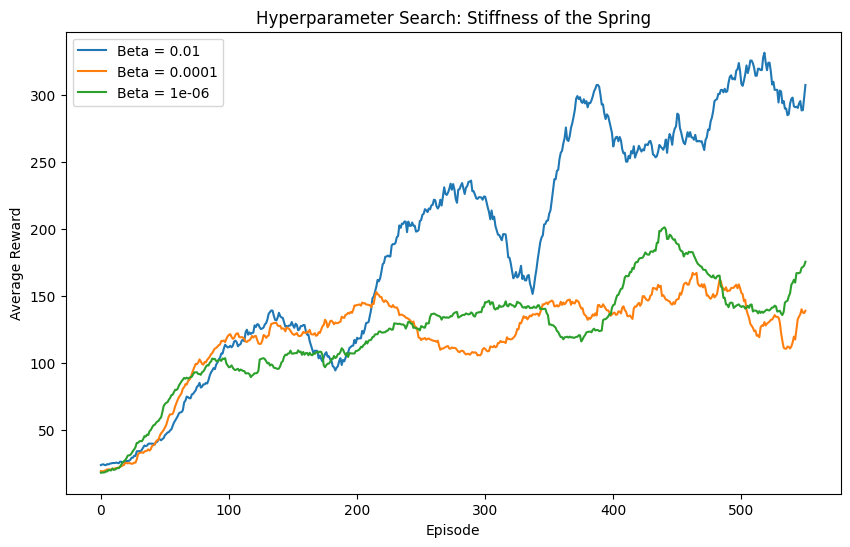

In [9]:
betas = [1e-2, 1e-4, 1e-6]
results = {}

for b in betas:
    model, stats = train_agent(beta=b, num_episodes=600)
    results[b] = (model, stats)

# Plotting Comparison
plt.figure(figsize=(10,6))
for b, (m, stats) in results.items():
    # Smoothing
    smoothed = np.convolve(stats, np.ones(50)/50, mode='valid')
    plt.plot(smoothed, label=f"Beta = {b}")

plt.title("Hyperparameter Search: Stiffness of the Spring")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

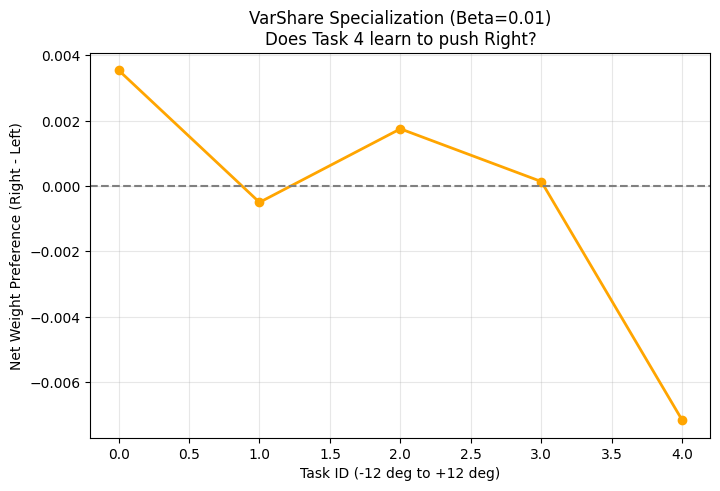

In [13]:
best_beta = 1e-2 # Change to whatever worked best
best_model = results[best_beta][0]

# Inspect Layer 3 (Output) Bias
# Task 0 (Left Lean) should favor Action 0 (Left force) -> Negative diff or specific bias pattern
# Task 4 (Right Lean) should favor Action 1 (Right force)

with torch.no_grad():
    # mu_specific shape: [num_tasks, out_features, in_features]
    # For a linear layer, bias is usually handled separately, 
    # but in our simple implementation we did F.linear(x, weight, bias). 
    # Wait, our VarShareLinear implementation didn't variationalize the BIAS! 
    # It only variationalized the WEIGHTS. 
    
    # Let's look at the weights connecting to Action 1 (Push Right).
    # Shape: [5, 2, 64] -> We take mean over the 64 inputs to see general tendency
    
    layer3_mus = best_model.l3.mu_specific.cpu().numpy() # [5, 2, 64]
    
    # Average "Push" per task for Action 0 (Left) vs Action 1 (Right)
    # If the weight is higher, Q-value is higher
    mean_weight_action_0 = layer3_mus[:, 0, :].mean(axis=1)
    mean_weight_action_1 = layer3_mus[:, 1, :].mean(axis=1)
    
    # The "Net Bias" (Right - Left preference)
    net_bias = mean_weight_action_1 - mean_weight_action_0
    
    plt.figure(figsize=(8,5))
    plt.plot([0,1,2,3,4], net_bias, marker='o', linewidth=2, color='orange')
    plt.axhline(0, linestyle='--', color='gray')
    plt.title(f"VarShare Specialization (Beta={best_beta})\nDoes Task 4 learn to push Right?")
    plt.xlabel("Task ID (-12 deg to +12 deg)")
    plt.ylabel("Net Weight Preference (Right - Left)")
    plt.grid(True, alpha=0.3)
    plt.show()

In [14]:
# --- BASELINE 1: INDEPENDENT DQN ---
# 5 completely separate networks. No sharing.
class IndependentDQN(nn.Module):
    def __init__(self, state_dim, action_dim, num_tasks):
        super().__init__()
        self.num_tasks = num_tasks
        
        # A list of independent networks
        self.networks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, action_dim)
            ) for _ in range(num_tasks)
        ])
        
    def forward(self, state, task_id):
        # We must route samples to the correct network. 
        # For batch efficiency, we mask and scatter.
        batch_size = state.shape[0]
        # Initialize output container
        outputs = torch.zeros(batch_size, 2, device=state.device)
        
        # Iterate over unique tasks in this batch to save compute
        unique_tasks = torch.unique(task_id)
        for t_id in unique_tasks:
            t_id_int = int(t_id.item())
            mask = (task_id == t_id)
            # Pass only the specific states to the specific network
            outputs[mask] = self.networks[t_id_int](state[mask])
            
        return outputs

# --- BASELINE 2: NAIVE SHARED DQN ---
# One network. Task ID is fed as an input (One-Hot).
class NaiveSharedDQN(nn.Module):
    def __init__(self, state_dim, action_dim, num_tasks):
        super().__init__()
        # Input grows by num_tasks for one-hot encoding
        self.net = nn.Sequential(
            nn.Linear(state_dim + num_tasks, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        self.num_tasks = num_tasks
        
    def forward(self, state, task_id):
        # Create One-Hot encoding on the fly
        # task_id: [batch] -> one_hot: [batch, num_tasks]
        task_onehot = F.one_hot(task_id, num_classes=self.num_tasks).float()
        
        # Concatenate State + Task
        x = torch.cat([state, task_onehot], dim=1)
        return self.net(x)

# --- BASELINE 3: STANDARD MULTI-HEAD (L2 REGULARIZED) ---
# Shared Trunk -> Task Specific Heads.
# We will apply L2 regularization ONLY to the heads during the training loop.
class MultiHeadDQN(nn.Module):
    def __init__(self, state_dim, action_dim, num_tasks):
        super().__init__()
        
        # Shared Trunk (Feature Extractor)
        self.trunk = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        
        # Independent Heads
        # We use a Parameter Tensor to allow batch processing (like VarShare) 
        # instead of ModuleList loop
        # Shape: [num_tasks, 64, action_dim]
        self.head_weight = nn.Parameter(torch.randn(num_tasks, 64, action_dim) * 0.1)
        self.head_bias = nn.Parameter(torch.zeros(num_tasks, action_dim))
        
    def forward(self, state, task_id):
        # 1. Shared Features
        features = self.trunk(state) # [batch, 64]
        
        # 2. Select Heads for this batch
        # [batch, 64, 2]
        weights = self.head_weight[task_id]
        biases = self.head_bias[task_id]
        
        # 3. Apply Heads
        # [batch, 1, 64] @ [batch, 64, 2] -> [batch, 1, 2] -> [batch, 2]
        out = torch.bmm(features.unsqueeze(1), weights).squeeze(1) + biases
        return out

In [15]:
def train_baseline(agent_type, agent_name, l2_lambda=0.0, num_episodes=500):
    print(f"\n--- Starting {agent_name} | L2 Lambda: {l2_lambda} ---")
    
    num_tasks = 5
    envs = [MultiTaskCartPole(i) for i in range(num_tasks)]
    
    # Initialize Policy and Target
    policy_net = agent_type(4, 2, num_tasks).to(device)
    target_net = agent_type(4, 2, num_tasks).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    
    optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
    buffer = MultiTaskBuffer(10000)
    
    epsilon = 1.0
    min_epsilon = 0.05
    epsilon_decay = 0.99
    batch_size = 128
    gamma = 0.99
    
    history = []
    
    for episode in range(num_episodes):
        task_id = random.randint(0, num_tasks-1)
        env = envs[task_id]
        state, _ = env.reset()
        total_reward = 0
        
        while True:
            # Action Selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    s_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                    t_t = torch.LongTensor([task_id]).to(device)
                    action = policy_net(s_t, t_t).argmax().item()
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            buffer.push(state, action, reward, next_state, done, task_id)
            state = next_state
            total_reward += reward
            
            # --- UPDATE ---
            if len(buffer) > batch_size:
                s, a, r, ns, d, t = buffer.sample(batch_size)
                
                q_vals = policy_net(s, t).gather(1, a)
                with torch.no_grad():
                    next_q = target_net(ns, t).max(1)[0].unsqueeze(1)
                    target = r + gamma * next_q * (1 - d)
                
                # Main MSE Loss
                loss = F.mse_loss(q_vals, target)
                
                # Conditional L2 Loss (Only for MultiHead)
                if isinstance(policy_net, MultiHeadDQN) and l2_lambda > 0:
                    # Penalize Head Weights (Push them to 0)
                    l2_reg = policy_net.head_weight.pow(2).sum() + policy_net.head_bias.pow(2).sum()
                    loss += l2_lambda * l2_reg
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            if done: break
            
        # Target Net Update
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())
            
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        history.append(total_reward)
        
        if episode % 50 == 0:
            avg = np.mean(history[-50:]) if len(history) > 0 else 0
            print(f"Ep {episode:03d} | Avg Reward: {avg:.1f} | Eps: {epsilon:.2f}")
            
    return history

In [16]:
# 1. Independent (Theoretical Upper Bound for Perf, Lower for Efficiency)
res_indep = train_baseline(IndependentDQN, "Independent", num_episodes=600)

# 2. Naive Shared (Likely to fail conflicting tasks)
res_naive = train_baseline(NaiveSharedDQN, "Naive Shared", num_episodes=600)

# 3. L2 Regularized (The direct competitor)
# We try a small lambda. Too big = Naive Shared. Too small = Independent.
res_l2 = train_baseline(MultiHeadDQN, "L2 Regularized", l2_lambda=0.01, num_episodes=600)

# 4. Re-run VarShare (if you don't have the history variable 'history_reward' saved)
# best_model, res_varshare = train_agent(beta=0.01, num_episodes=600) 
# Note: Ensure you use the same function name you defined earlier for VarShare

# --- PLOTTING ---
def smooth(x, w=50):
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(12, 6))

# Assuming 'history_reward' contains your VarShare data
# If you re-ran it, use 'res_varshare'
plt.plot(smooth(history_reward), label="VarShare (Beta=0.01)", linewidth=3, color='blue')

plt.plot(smooth(res_indep), label="Independent", linestyle='--', color='green')
plt.plot(smooth(res_naive), label="Naive Shared", linestyle='--', color='red')
plt.plot(smooth(res_l2), label="L2 Regularized", linestyle='--', color='orange')

plt.title("Benchmarking Conflict Resolution: Multi-Task CartPole")
plt.xlabel("Episode")
plt.ylabel("Average Reward (Smoothed)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


--- Starting Independent | L2 Lambda: 0.0 ---
Ep 000 | Avg Reward: 19.3 | Eps: 0.99
Ep 050 | Avg Reward: 17.5 | Eps: 0.60
Ep 100 | Avg Reward: 49.7 | Eps: 0.36
Ep 150 | Avg Reward: 128.6 | Eps: 0.22
Ep 200 | Avg Reward: 168.6 | Eps: 0.13
Ep 250 | Avg Reward: 207.6 | Eps: 0.08
Ep 300 | Avg Reward: 159.6 | Eps: 0.05
Ep 350 | Avg Reward: 152.2 | Eps: 0.05
Ep 400 | Avg Reward: 172.2 | Eps: 0.05
Ep 450 | Avg Reward: 131.5 | Eps: 0.05
Ep 500 | Avg Reward: 148.2 | Eps: 0.05
Ep 550 | Avg Reward: 182.8 | Eps: 0.05

--- Starting Naive Shared | L2 Lambda: 0.0 ---
Ep 000 | Avg Reward: 35.6 | Eps: 0.99
Ep 050 | Avg Reward: 21.1 | Eps: 0.60
Ep 100 | Avg Reward: 63.9 | Eps: 0.36
Ep 150 | Avg Reward: 126.6 | Eps: 0.22
Ep 200 | Avg Reward: 114.9 | Eps: 0.13
Ep 250 | Avg Reward: 138.2 | Eps: 0.08
Ep 300 | Avg Reward: 122.4 | Eps: 0.05
Ep 350 | Avg Reward: 129.4 | Eps: 0.05
Ep 400 | Avg Reward: 122.6 | Eps: 0.05
Ep 450 | Avg Reward: 132.3 | Eps: 0.05
Ep 500 | Avg Reward: 143.5 | Eps: 0.05
Ep 550 | Avg R

NameError: name 'history_reward' is not defined

<Figure size 1200x600 with 0 Axes>

--- Starting L2 Baseline Sweep ---

--- Starting L2 (Lam=0.01) | L2 Lambda: 0.01 ---
Ep 000 | Avg Reward: 6.8 | Eps: 0.99
Ep 050 | Avg Reward: 19.4 | Eps: 0.60
Ep 100 | Avg Reward: 46.5 | Eps: 0.36
Ep 150 | Avg Reward: 124.2 | Eps: 0.22
Ep 200 | Avg Reward: 179.2 | Eps: 0.13
Ep 250 | Avg Reward: 185.9 | Eps: 0.08
Ep 300 | Avg Reward: 121.8 | Eps: 0.05
Ep 350 | Avg Reward: 160.0 | Eps: 0.05
Ep 400 | Avg Reward: 211.6 | Eps: 0.05
Ep 450 | Avg Reward: 168.5 | Eps: 0.05
Ep 500 | Avg Reward: 176.9 | Eps: 0.05
Ep 550 | Avg Reward: 169.0 | Eps: 0.05

--- Starting L2 (Lam=0.001) | L2 Lambda: 0.001 ---
Ep 000 | Avg Reward: 10.7 | Eps: 0.99
Ep 050 | Avg Reward: 20.9 | Eps: 0.60
Ep 100 | Avg Reward: 63.8 | Eps: 0.36
Ep 150 | Avg Reward: 120.2 | Eps: 0.22
Ep 200 | Avg Reward: 150.3 | Eps: 0.13
Ep 250 | Avg Reward: 142.1 | Eps: 0.08
Ep 300 | Avg Reward: 146.2 | Eps: 0.05
Ep 350 | Avg Reward: 143.3 | Eps: 0.05
Ep 400 | Avg Reward: 157.5 | Eps: 0.05
Ep 450 | Avg Reward: 172.0 | Eps: 0.05
Ep 500 | Avg

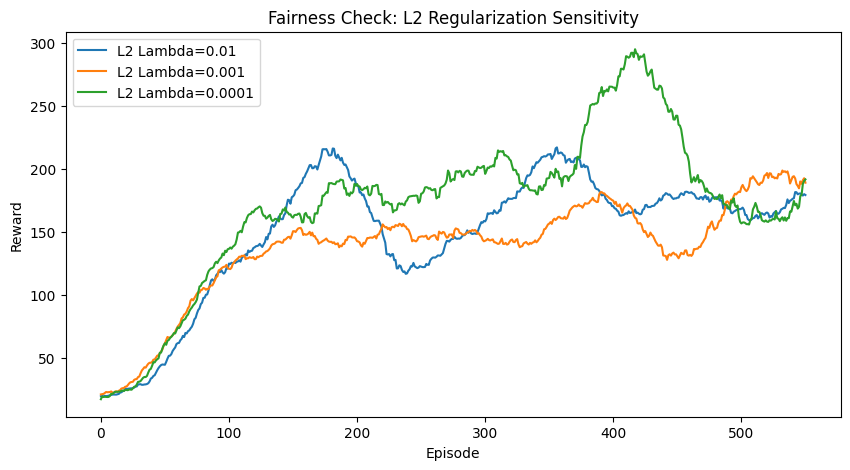

In [17]:
# --- HYPERPARAMETER SEARCH FOR L2 BASELINE ---
l2_lambdas = [1e-2, 1e-3, 1e-4]
l2_results = {}

print("--- Starting L2 Baseline Sweep ---")

for lam in l2_lambdas:
    # We use the MultiHeadDQN class we defined earlier
    # It has the logic to apply l2_lambda to the heads
    history = train_baseline(MultiHeadDQN, f"L2 (Lam={lam})", 
                             l2_lambda=lam, num_episodes=600)
    l2_results[lam] = history

# Find the best L2 Lambda
final_rewards = {k: np.mean(v[-50:]) for k, v in l2_results.items()}
best_lambda = max(final_rewards, key=final_rewards.get)
best_l2_history = l2_results[best_lambda]

print(f"\nWinner of L2 Sweep: Lambda={best_lambda} (Reward: {final_rewards[best_lambda]:.2f})")

# Visualize the Sweep
plt.figure(figsize=(10, 5))
for lam, hist in l2_results.items():
    plt.plot(np.convolve(hist, np.ones(50)/50, mode='valid'), label=f"L2 Lambda={lam}")
plt.title("Fairness Check: L2 Regularization Sensitivity")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

In [ ]:
# Assumes you have these variables in memory from previous cells:
# 1. history_reward (from your successful VarShare run)
# 2. best_l2_history (from the sweep above)

# If you haven't run Independent/Naive yet, run them quickly:
print("Running Independent Baseline...")
res_indep = train_baseline(IndependentDQN, "Independent", num_episodes=600)

print("Running Naive Shared Baseline...")
res_naive = train_baseline(NaiveSharedDQN, "Naive Shared", num_episodes=600)

# --- THE FINAL PLOT ---
plt.figure(figsize=(12, 7))
def smooth(x, w=50):
    return np.convolve(x, np.ones(w)/w, mode='valid')

# 1. VarShare (Our Method)
plt.plot(smooth(history_reward), label="VarShare (Beta=0.01)", 
         linewidth=3, color='blue')

# 2. The Strongest Competitor (Best L2)
plt.plot(smooth(best_l2_history), label=f"L2 Baseline (Best $\lambda$={best_lambda})", 
         linestyle='--', linewidth=2, color='orange')

# 3. The Theoretical Bounds
plt.plot(smooth(res_indep), label="Independent (Upper Bound)", 
         linestyle=':', color='green', alpha=0.7)
plt.plot(smooth(res_naive), label="Naive Shared (Lower Bound)", 
         linestyle=':', color='red', alpha=0.7)

plt.title("Multi-Task CartPole: VarShare vs. Tuned Baselines")
plt.xlabel("Episode")
plt.ylabel("Average Reward (Smoothed)")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()